<a href="https://colab.research.google.com/github/shobhittya/-web-server/blob/master/Image_Forgery_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
CUDA_LAUNCH_BLOCKING = "1"

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from tqdm.notebook import tqdm

import time
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import math
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm

In [ ]:
#Data Transformation and Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/xhlulu/140k-real-and-fake-faces"

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 3.75G/3.75G [00:29<00:00, 135MB/s]


In [ ]:
data_dir = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
dataset = ImageFolder(data_dir+'/test', transform=ToTensor())
# print(dataset.classes)

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])

image_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=1) for x in ['train', 'test']}
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=1, shuffle=False, num_workers=1)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

using device: cuda:0


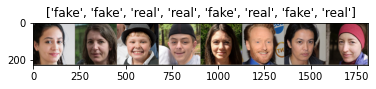

In [ ]:
def imshow(imgs, title=None):
    #imshow for img(tensor)
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(image_dataloader['train']))

imgs = torchvision.utils.make_grid(inputs)

imshow(imgs, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(model, num_imgs=4):
    train_phase = model.training
    model.eval()
    total_images_processed = 0
    fig = plt.figure()

    with torch.no_grad():
        #for inputs, labels in tqdm(image_dataloader['val']):
        for index, (inputs, labels) in enumerate(image_dataloader['test']):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                total_images_processed += 1
                ax = plt.subplot(num_imgs//2, 2, total_images_processed)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if total_images_processed == num_imgs:
                    model.train(mode=train_phase)
                    return
        model.train(mode=train_phase)

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs=30, early_stopping=True, save_name='CoAtNet'):
    last_loss = 100
    patience = 5
    trigger_times = 0

    total_start = time.time()

    total_train_accuracy = []
    total_train_loss = []
    total_val_accuracy = []
    total_val_loss = []

    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        start = time.time()
        print('Epoch {} / {}'.format(epoch, num_epochs-1))
        print('-' * 20)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            #for inputs, labels in tqdm(image_dataloader[phase]):
            for index, (inputs, labels) in enumerate(image_dataloader[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.float() / dataset_sizes[phase]

            if phase == 'train':
                total_train_loss.append(epoch_loss)
                total_train_accuracy.append(epoch_accuracy)
            if phase == 'test':
                total_val_loss.append(epoch_loss)
                total_val_accuracy.append(epoch_accuracy)

            print('{} Loss: {:.5f} Accuracy: {:.5f}'.format(phase, epoch_loss, epoch_accuracy))

            if phase == 'test' and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_loss = epoch_loss
                best_model_weight = copy.deepcopy(model.state_dict())

            if early_stopping and phase == 'test':
                if last_loss < epoch_loss:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print('Early stopping at epoch {}'.format(epoch))
                        total_time_elapsed = np.round(time.time() - total_start, 3)
                        print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
                        print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))
                        model.load_state_dict(best_model_weight)
                        return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss
                else:
                    trigger_times = 0
                last_loss = epoch_loss       
        
        #save on every 10 epochs
        if epoch % 10 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'epoch': epoch
            }, '/content/{}_epoch_{}.pt'.format(save_name, epoch))

        end = np.round(time.time() - start, 3)
        print('Epoch {}: {}s\n'.format(epoch, end))

    total_time_elapsed = np.round(time.time() - total_start, 3)
    print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
    print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))

    model.load_state_dict(best_model_weight)
    return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss


In [ ]:
!pip install einops

In [ ]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Rearrange


def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return x + self.conv(x)


class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x


In [ ]:
class CoAtNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=1000, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 32, iw // 32))

        self.pool = nn.AvgPool2d(ih // 32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)


def coatnet_0():
    num_blocks = [2, 2, 3, 5, 2]            # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=2)


def coatnet_1():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_2():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [128, 128, 256, 512, 1026]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_3():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_4():
    num_blocks = [2, 2, 12, 28, 2]          # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


if __name__ == '__main__':
    img = torch.randn(1, 3, 224, 224)

    net = coatnet_0()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_1()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_2()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_3()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_4()
    out = net(img)
    print(out.shape, count_parameters(net))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 2]) 17023160
torch.Size([1, 1000]) 33170624
torch.Size([1, 1000]) 55767564
torch.Size([1, 1000]) 117724480
torch.Size([1, 1000]) 203960368


In [ ]:
from random import randint, choices
import random
from datetime import datetime
from math import log2
# from coatnet import CoAtNet

params = {
    'channels': [[32, 64, 128, 64, 32], [64, 128, 256, 128, 64], [128, 256, 512, 256, 128], [256, 512, 1024, 512, 256], [16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [64, 128, 256, 512, 1024]],
    'block_types': [['C', 'C', 'C', 'C'], ['C', 'C', 'C', 'T'], ['C', 'C', 'T', 'T']],
    'lr': [0.01, 0.05, 0.001, 0.005]
}

hyper_search = 5
search_acc = 0
best_params = ''
for i in range(hyper_search):
    random.seed(datetime.now())
    rand_channels = randint(0, 6)
    rand_channels_values =  params['channels'][rand_channels]
    rand_block_type = randint(0, 2)
    rand_lr = randint(0, 3)
    rand_block = [int(log2(i)) for i in rand_channels_values]
    for i in range(len(rand_block)):                            #make sure 1st, 2nd and 5th entries are 2
        if i == 0 or i == 1 or i == len(rand_block)-1:
            rand_block[i] = 2
        else:
            if rand_block[i] % 2 == 1:                          #make sure the number is even
                rand_block[i] += 1
    
    model = CoAtNet((224, 224), 3, num_blocks=rand_block, channels=params['channels'][rand_channels], block_types=params['block_types'][rand_block_type], num_classes=2)
    optimizer = optim.SGD(model.fc.parameters(), lr=params['lr'][rand_lr], momentum=0.9)
    model = model.to(device)
    learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    current_parameters = {
        'lr': params['lr'][rand_lr],
        'channels': params['channels'][rand_channels],
        'block_type': params['block_types'][rand_block_type],
        'rand_block': rand_block
    }
    print('Current parameters:', current_parameters)
    model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss = train(model, criterion, optimizer, learning_rate_scheduler, num_epochs=11)

    max_acc = max(total_val_accuracy)
    max_acc_idx = total_val_accuracy.index(max_acc)
    min_loss = total_val_loss[max_acc_idx]
    
    print('max accuracy: {} min loss: {}'.format(max_acc, min_loss))

    if max_acc > search_acc:
        best_params = current_parameters
        search_acc = max_acc
    model = model.cpu()
print(best_params)


Current parameters: {'lr': 0.01, 'channels': [32, 64, 128, 64, 32], 'block_type': ['C', 'C', 'C', 'T'], 'rand_block': [2, 2, 8, 6, 2]}
Epoch 0 / 10
--------------------
train Loss: 1.06309 Accuracy: 0.51825
test Loss: 1.91675 Accuracy: 0.49970
Epoch 0: 735.081s

Epoch 1 / 10
--------------------
train Loss: 1.10297 Accuracy: 0.52151
test Loss: 0.74868 Accuracy: 0.53600
Epoch 1: 735.012s

Epoch 2 / 10
--------------------
train Loss: 1.07554 Accuracy: 0.51881
test Loss: 2.38531 Accuracy: 0.50000
Epoch 2: 735.628s

Epoch 3 / 10
--------------------
train Loss: 0.70823 Accuracy: 0.54455
test Loss: 0.70194 Accuracy: 0.55025
Epoch 3: 731.824s

Epoch 4 / 10
--------------------
train Loss: 0.71017 Accuracy: 0.54075
test Loss: 0.69244 Accuracy: 0.55675
Epoch 4: 736.253s

Epoch 5 / 10
--------------------
train Loss: 0.70706 Accuracy: 0.54073
test Loss: 0.69896 Accuracy: 0.54760
Epoch 5: 737.302s

Epoch 6 / 10
--------------------
train Loss: 0.68148 Accuracy: 0.56751
test Loss: 0.69812 Accura

In [ ]:
model = coatnet_0()
optimizer = optim.SGD(model.fc.parameters(), lr=0.005, momentum=0.9)
learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

In [ ]:
model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss = train(model, criterion, optimizer, \
    learning_rate_scheduler, num_epochs=500, early_stopping=True, save_name='CoAtNet0')